In [2]:
# Celda 1: Imports
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    RocCurveDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Dispositivo: {device}")

c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🖥️  Dispositivo: cuda


In [3]:
# Celda 2: Configuración de los 3 mejores modelos
# 🏆 Los mejores modelos entrenados para cada dataset

models_to_compare = {
    "codigos": {
        "name": "BERT Spanish Cased (Códigos)",
        "path": r"C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\models\dccuchile_bert-base-spanish-wwm-cased_codigos_final",
        "dataset_path": r"C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\TFG\dataset\diagnosticos_binarios_codigos.csv",
        "target_logic": lambda x: 1 if "F20" in x and "F20.89" not in x else 0,
        "color": "red"
    },
    "descripciones": {
        "name": "BERT Spanish Uncased (Descripciones)", 
        "path": r"C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\models\dccuchile_bert-base-spanish-wwm-uncased_descripciones_final",
        "dataset_path": r"C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\TFG\dataset\diagnosticos_binarios_descripciones.csv",
        "target_logic": lambda x: 1 if "Esquizofrenia" in x and "Otros tipos de esquizofrenia" not in x else 0,
        "color": "blue"
    },
    "combinado": {
        "name": "BERT Spanish Cased (Combinado)",
        "path": r"C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\models\dccuchile_bert-base-spanish-wwm-cased_combinado_final",
        "dataset_path": r"C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\TFG\dataset\diagnosticos_binarios_combinados.csv", 
        "target_logic": lambda x: 1 if "F20" in x and "F20.89" not in x else 0,
        "color": "green"
    }
}

print("🔧 Modelos configurados para comparación:")
for dataset_type, config in models_to_compare.items():
    print(f"• {dataset_type}: {config['name']}")

🔧 Modelos configurados para comparación:
• codigos: BERT Spanish Cased (Códigos)
• descripciones: BERT Spanish Uncased (Descripciones)
• combinado: BERT Spanish Cased (Combinado)


In [4]:
# Celda 3: Función para evaluar modelo
def evaluate_model(dataset_type, config):
    """Evalúa un modelo en su dataset correspondiente"""
    
    print(f"\n🚀 Evaluando: {config['name']}")
    
    # Cargar dataset
    df = pd.read_csv(config["dataset_path"], sep="|")
    diag_cols = [col for col in df.columns if col.startswith("Diag")]
    df["text"] = df[diag_cols].fillna("").apply(lambda x: " ".join(x), axis=1)
    df["label"] = df["DIAG PSQ"].apply(config["target_logic"])
    
    # División de datos (mismo seed para consistencia)
    X_train, X_test, y_train, y_test = train_test_split(
        df["text"], df["label"], 
        stratify=df["label"], 
        test_size=0.2, 
        random_state=42
    )
    
    print(f"📊 Dataset {dataset_type}:")
    print(f"   Total ejemplos: {len(df)}")
    print(f"   Test set: {len(X_test)}")
    print(f"   Distribución: {df['label'].value_counts().to_dict()}")
    
    # Cargar modelo
    model = AutoModelForSequenceClassification.from_pretrained(config["path"]).to(device)
    tokenizer = AutoTokenizer.from_pretrained(config["path"])
    
    # Tokenizar
    inputs = tokenizer(X_test.tolist(), padding=True, truncation=True, return_tensors="pt").to(device)
    
    # Predicción
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1).cpu().numpy()
    
    y_pred = probs.argmax(axis=1)
    y_proba = probs[:, 1]
    
    # Calcular métricas
    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, average='binary', zero_division=0),
        "recall": recall_score(y_test, y_pred, average='binary', zero_division=0),
        "f1": f1_score(y_test, y_pred, average='binary', zero_division=0),
        "roc_auc": auc(*roc_curve(y_test, y_proba)[:2])
    }
    
    print(f"✅ Métricas {dataset_type}:")
    for metric, value in metrics.items():
        print(f"   {metric.upper()}: {value:.4f}")
    
    return {
        "dataset_type": dataset_type,
        "name": config["name"],
        "color": config["color"],
        "metrics": metrics,
        "y_test": y_test,
        "y_pred": y_pred,
        "y_proba": y_proba
    }

In [5]:
# Celda 4: Evaluar todos los modelos
print("🏁 Iniciando evaluación comparativa...")

results = {}
for dataset_type, config in models_to_compare.items():
    results[dataset_type] = evaluate_model(dataset_type, config)

🏁 Iniciando evaluación comparativa...

🚀 Evaluando: BERT Spanish Cased (Códigos)
📊 Dataset codigos:
   Total ejemplos: 1997
   Test set: 400
   Distribución: {0: 1385, 1: 612}
✅ Métricas codigos:
   ACCURACY: 0.7550
   PRECISION: 0.5796
   RECALL: 0.7398
   F1: 0.6500
   ROC_AUC: 0.8336

🚀 Evaluando: BERT Spanish Uncased (Descripciones)
📊 Dataset descripciones:
   Total ejemplos: 1997
   Test set: 400
   Distribución: {0: 1394, 1: 603}
✅ Métricas descripciones:
   ACCURACY: 0.8875
   PRECISION: 0.8519
   RECALL: 0.7603
   F1: 0.8035
   ROC_AUC: 0.9521

🚀 Evaluando: BERT Spanish Cased (Combinado)
📊 Dataset combinado:
   Total ejemplos: 1997
   Test set: 400
   Distribución: {0: 1385, 1: 612}
✅ Métricas combinado:
   ACCURACY: 0.9025
   PRECISION: 0.8043
   RECALL: 0.9024
   F1: 0.8506
   ROC_AUC: 0.9597


In [6]:
# Celda 5: Tabla comparativa de métricas
print("\n📊 TABLA COMPARATIVA DE RESULTADOS")
print("=" * 80)

# Crear DataFrame para comparación
comparison_data = []
for dataset_type, result in results.items():
    row = {
        "Modelo": result["name"],
        "Dataset": dataset_type.title(),
        "Accuracy": result["metrics"]["accuracy"],
        "Precision": result["metrics"]["precision"], 
        "Recall": result["metrics"]["recall"],
        "F1-Score": result["metrics"]["f1"],
        "ROC AUC": result["metrics"]["roc_auc"]
    }
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.round(4).to_string(index=False))

# Encontrar mejores resultados
print(f"\n🏆 MEJORES RESULTADOS:")
print(f"Mejor Accuracy: {comparison_df['Accuracy'].max():.4f} - {comparison_df.loc[comparison_df['Accuracy'].idxmax(), 'Modelo']}")
print(f"Mejor Precision: {comparison_df['Precision'].max():.4f} - {comparison_df.loc[comparison_df['Precision'].idxmax(), 'Modelo']}")
print(f"Mejor Recall: {comparison_df['Recall'].max():.4f} - {comparison_df.loc[comparison_df['Recall'].idxmax(), 'Modelo']}")
print(f"Mejor F1-Score: {comparison_df['F1-Score'].max():.4f} - {comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'Modelo']}")
print(f"Mejor ROC AUC: {comparison_df['ROC AUC'].max():.4f} - {comparison_df.loc[comparison_df['ROC AUC'].idxmax(), 'Modelo']}")


📊 TABLA COMPARATIVA DE RESULTADOS
                              Modelo       Dataset  Accuracy  Precision  Recall  F1-Score  ROC AUC
        BERT Spanish Cased (Códigos)       Codigos    0.7550     0.5796  0.7398    0.6500   0.8336
BERT Spanish Uncased (Descripciones) Descripciones    0.8875     0.8519  0.7603    0.8035   0.9521
      BERT Spanish Cased (Combinado)     Combinado    0.9025     0.8043  0.9024    0.8506   0.9597

🏆 MEJORES RESULTADOS:
Mejor Accuracy: 0.9025 - BERT Spanish Cased (Combinado)
Mejor Precision: 0.8519 - BERT Spanish Uncased (Descripciones)
Mejor Recall: 0.9024 - BERT Spanish Cased (Combinado)
Mejor F1-Score: 0.8506 - BERT Spanish Cased (Combinado)
Mejor ROC AUC: 0.9597 - BERT Spanish Cased (Combinado)


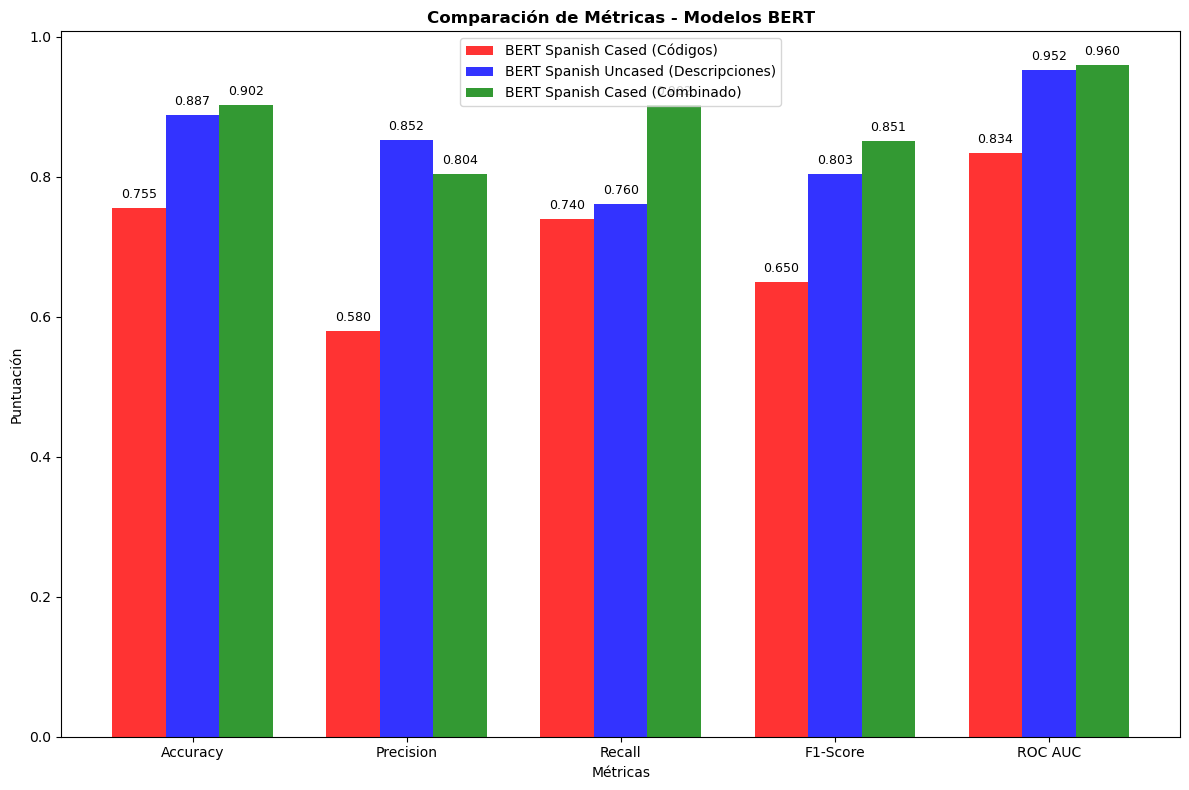

In [7]:
# Celda 6: Gráfico comparativo de métricas
fig, ax = plt.subplots(figsize=(12, 8))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']
metric_keys = {
    'Accuracy': 'accuracy',
    'Precision': 'precision',
    'Recall': 'recall',
    'F1-Score': 'f1',
    'ROC AUC': 'roc_auc'
}
x = np.arange(len(metrics))
width = 0.25

for i, (dataset_type, result) in enumerate(results.items()):
    values = [result["metrics"][metric_keys[m]] for m in metrics]
    ax.bar(x + i*width, values, width, 
           label=result["name"], 
           color=result["color"], 
           alpha=0.8)

# Configurar las etiquetas del eje X
ax.set_xticks(x + width)  # Centrar las etiquetas
ax.set_xticklabels(metrics)  # Usar los nombres de las métricas
ax.set_xlabel('Métricas')
ax.set_ylabel('Puntuación')
ax.set_title('Comparación de Métricas - Modelos BERT', fontweight='bold')
ax.legend()

# Añadir valores en las barras
for i, (dataset_type, result) in enumerate(results.items()):
    values = [result["metrics"][metric_keys[m]] for m in metrics]
    for j, v in enumerate(values):
        ax.text(j + i*width, v + 0.01, f'{v:.3f}', 
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('metricas_comparativas.png', dpi=300)
plt.show()

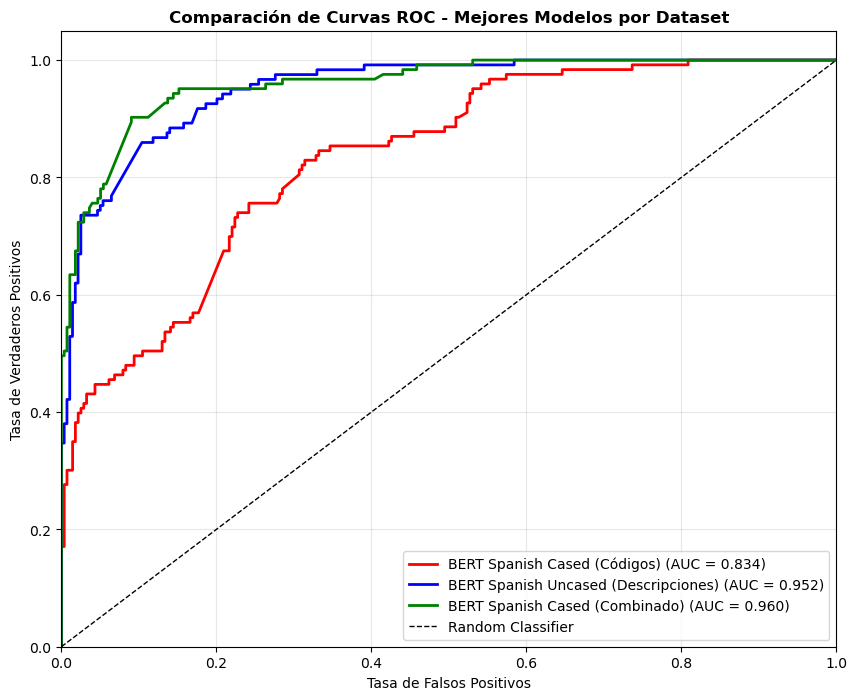

In [8]:
# Celda 7: Curvas ROC comparativas
plt.figure(figsize=(10, 8))

for dataset_type, result in results.items():
    fpr, tpr, _ = roc_curve(result["y_test"], result["y_proba"])
    roc_auc = result["metrics"]["roc_auc"]
    
    plt.plot(fpr, tpr, 
             color=result["color"],
             linewidth=2,
             label=f'{result["name"]} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Comparación de Curvas ROC - Mejores Modelos por Dataset', fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.savefig('curvas_roc_comparativas.png', dpi=300)
plt.show()

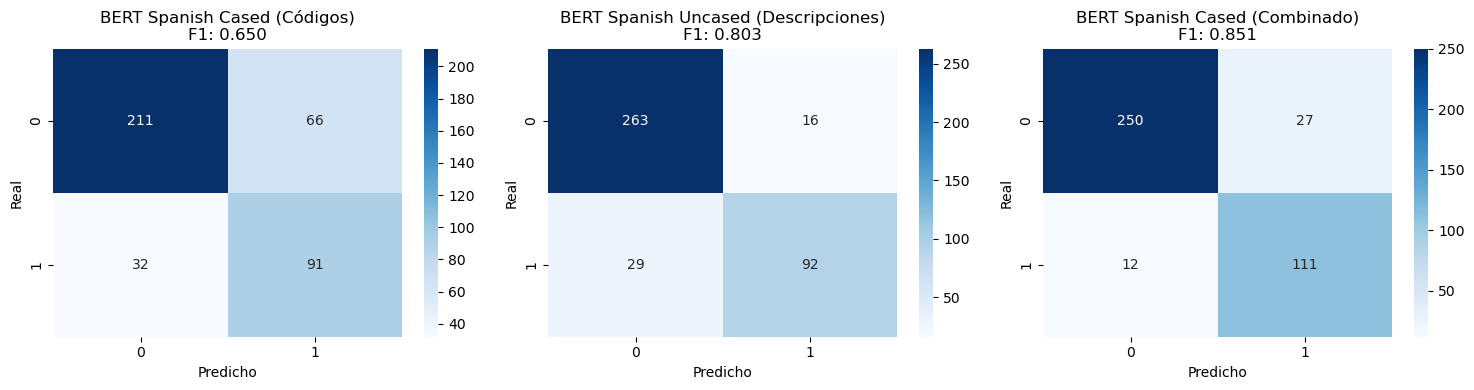

In [9]:
# Celda 8: Matrices de confusión
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (dataset_type, result) in enumerate(results.items()):
    cm = confusion_matrix(result["y_test"], result["y_pred"])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'{result["name"]}\nF1: {result["metrics"]["f1"]:.3f}')
    axes[i].set_xlabel('Predicho')
    axes[i].set_ylabel('Real')

plt.tight_layout()
plt.savefig('matrices_confusion.png', dpi=300)
plt.show()

In [10]:
# Celda 9: Guardar resultados
# Guardar tabla comparativa
comparison_df.to_csv(r"C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\results\BERT_comparacion.csv", index=False)

# Guardar métricas detalladas
detailed_results = {}
for dataset_type, result in results.items():
    detailed_results[dataset_type] = {
        "model_name": result["name"],
        "metrics": result["metrics"]
    }

import json
with open(r"C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\results\resultados_detallados_bert.json", "w") as f:
    json.dump(detailed_results, f, indent=2)

print("💾 Resultados guardados:")
print("• results/comparacion_mejores_modelos_bert.csv")
print("• results/resultados_detallados_bert.json")

print(f"\n🎯 RESUMEN FINAL:")
print(f"Se compararon {len(results)} modelos BERT entrenados en diferentes datasets")
print(f"Cada modelo fue evaluado en su dataset correspondiente")
best_f1_model = comparison_df.loc[comparison_df['F1-Score'].idxmax()]
print(f"Mejor modelo general (F1-Score): {best_f1_model['Modelo']} - {best_f1_model['F1-Score']:.4f}")

💾 Resultados guardados:
• results/comparacion_mejores_modelos_bert.csv
• results/resultados_detallados_bert.json

🎯 RESUMEN FINAL:
Se compararon 3 modelos BERT entrenados en diferentes datasets
Cada modelo fue evaluado en su dataset correspondiente
Mejor modelo general (F1-Score): BERT Spanish Cased (Combinado) - 0.8506
